# FREE-ENERGY PRINCIPLE (FEP) TUTORIAL
## Perception as an inference process - predictive processing

**Author:** [Pablo Lanillos](https://www.ru.nl/personen/lanillos-p/) Assistant Professor Cognitive AI. Donders Institute for Brain, Cognition and Behaviour. The Netherlands.

**Adapted to NeurIPS lecture by:** Marius Marten Kästingschäfer, Marcel van Gerven


## Background reading

Papers:
+ Bogacz, R. (2017). A tutorial on the free-energy framework for modelling perception and learning. Journal of mathematical psychology, 76, 198-211.
+ Lanillos, P., & Cheng, G. (2018, October). Adaptive robot body learning and estimation through predictive coding. In 2018 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS) (pp. 4083-4090). IEEE.
+ Sancaktar, C., van Gerven, M., & Lanillos, P. (2019). End-to-end pixel-based deep active inference for body perception and action. arXiv preprint arXiv:2001.05847.
+ Friston, K. J., Daunizeau, J., Kilner, J., & Kiebel, S. J. (2010). Action and behavior: a free-energy formulation. Biological cybernetics, 102(3), 227-260.
+ Buckley, C. L., Kim, C. S., McGregor, S., & Seth, A. K. (2017). The free energy principle for action and perception: A mathematical review. Journal of Mathematical Psychology, 81, 55-79.

Blog:
* https://msrmblog.github.io/is-this-my-body-1/
* https://msrmblog.github.io/is-this-my-body-2/

## Problem definition

We have an agent that lives in a 1-dimensional space environment.  The agent goal is to infer its position in the space $x$ given the sensory input $s$. It has a sensor that it is able to sense its rotation over the environment. After exploring the 1-dimensional space, it has learnt a generative model of the world depending on its internal state $x$, which is $x^2$ - See image below. *This generative model defines the prediction of the sensory input depending on its internal state.*

![toy_problem_def.jpg](toy_problem_def.jpg)



The agent starts with a wrong belief of his internal state, which yields into a bad estimation of it position. As it can be seen in the image below his actual position is misaligned with his estimated position. We will use a simplified model of predictive processing minimizing the Variational Free Energy (VFE) to solve this task.


![Problem1.png](Problem1.png)

## Overview
In this toy example you will see a basic FEP model at work. The following will be done: 

a. Look at the formulas for the variational free energy  
b. Implement the generative model  
c. Run the generative model   
d. Inspect the results   

## Tasks:
1. Implement the <font color='blue'>updating step</font> for the generative model


2. Test its robustness in regard to <font color='blue'>different parameter</font> intializations 
    - What effects does it have if the initial values are further away from the agents actual position?
    - What values will make the system to be stable? 
    - What if we initialize the belief with a negative position?
    - What happens if we add noise to the sensory measurement?
    
    
3. Describe according to the FEP how the agent would <font color='blue'>act</font> in this environment

## Part a: Variational Free Energy (VFE) - with the Laplace approximation

$ F = KL[q(x)|| p(x|s)] -ln p(s) \rightarrow_\text{laplace} F = -\ln p(s,\mu) - \frac{1}{2}(\ln |\Sigma| + \ln 2\pi)$ 


Perception is defined as the minimization of $F$:

 $\mu = \arg\min_s F(\mu, s)$
 
We compute it using the following differential equation (gradient optimization):

 $ \dot{\mu} = -\frac{\partial F}{\partial \mu} = - \frac{\partial \ln p(s|\mu) p(\mu)}{\partial \mu}$ (Eq. 1)

 Assuming that the sensors measurements $s$ are defined by a generative model with Gaussian noise $z$:  $s = g(\mu) + z$

 We have:

 $ \dot{\mu} = \frac{\partial g(\mu)}{\partial \mu}^T \Sigma_s^{-1} (s-g(\mu)) $ (Eq. 2)

### Question a.1: Write down the derivation from (Eq. 1) to (Eq. 2)

1. The likelihood $p(s|\mu)$ that defines the generative model follows a Normal distribution with mean $\mu$ and $\sigma$ standard deviation:
$p(s|mu) \sim \mathcal{N}(s; \mu, \sigma^2)$ 

2. The prior $p(\mu)$ is assumed to be uniform

*Tip: use the function of the Normal density function (pdf). [wiki](https://en.wikipedia.org/wiki/Normal_distribution)*

### Answer a.1: 

$ \dot{\mu} = - \frac{\partial \ln p(s|\mu) p(\mu)}{\partial \mu}$

$ \dot{\mu} = - \frac{\partial \ln p(s|\mu)}{\partial \mu}$

$ \dot{\mu} = - \frac{\partial \ln \frac{1}{\sqrt{2\pi\Sigma}}e^{-\frac{1}{2}\frac{(s-g(\mu))^2}{\Sigma}}}{\partial \mu} $

$ \dot{\mu} = - \frac{\partial \ln g(s; g(\mu), \Sigma)}{\partial \mu}$

$ \dot{\mu} = \frac{\partial g(\mu)}{\partial \mu} \Sigma^{-1} (s - g(\mu)) $

$ \dot{\mu} = \frac{\partial g(\mu)}{\partial \mu}^T \Sigma_s^{-1} (s-g(\mu)) $

## Part b: Generative model definition

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generative model definition
def g(x):     # forward model
  return x**2

def dg(x):    # inverse model
  return 2*x

In [2]:
# Plotting actual and inferred position of the agent

def plot_results(real_x, mu_0):

    x = np.linspace(-2, 2, 1000)
    y = np.linspace(2, 2, 1000)
    plt.plot(x, y, 'k')
    plt.plot(real_x, 2, 'r8', markersize=15)
    plt.plot(mu_0, 2, 'b8', markersize=15)
    plt.plot(0, 2, 'k|', markersize=8)
    
    plt.xlim([-1,1])  # adjust plot when choosing values outside of range -1 and 1
    plt.legend(['Space', 'actual position', 'estimated position', 'x=0'])
    plt.xticks([])
    plt.yticks([])
    plt.title('Estimated vs. actual position')

    plt.show()

## Initialization

In [3]:
dt = 0.001    # integration step
ftime = 1   # maximum time considered

time = np.arange(0, ftime, dt) # Time array
N = time.shape[0] # Steps

real_x = 0.1    # real position of the ball
real_x_dot = 0  # change on the position 

mu_0 = 0.5      # internal belief 
mu_dot = 0.0     # change on the internal belief

sigma_s = 0.01    # variance of the sensory process

### Question b.1: Compute the sensor measurement

In [10]:
s = g(real_x)

### Question.b.2: Compute the predicted sensor value depending on the brain variable $\mu$

In [9]:
mu_dot = dg(mu_0) * sigma_s ** -1 * (s - g(mu_0))

### Question b.3: Compute the prediction error

In [11]:
pe = (s - g(mu_0)) / sigma_s

## Part c: Implementing the FEP model

### Question c.1: Write the function fep(parameters) that executes the FEP model

In [60]:
def fep(real_x, mu_0):
    """
    Takes real position real_x and belief in position mu_0 as input and runs FEP for N timesteps

    Returns data which is a 4 x N array that collects s, real_x, mu_0 and e_s for N timesteps

    """
    # Initialize
    N = 1000
    dt = 0.001
    data = np.empty((4, N))
    
    # Run for N timesteps
    for t in range(N):
        # Computations
        s = g(real_x)
        mu_dot = dg(mu_0) * sigma_s ** -1 * (s - g(mu_0))
        e_s = (s - g(mu_0))
        
        # Update mu
        mu_0 += mu_dot * dt
        
        # Data
        data[0,t] = s
        data[1,t] = real_x
        data[2,t] = mu_0
        data[3,t] = e_s
    return data

# Initialization 
real_x = 0.1    # real position of the ball
mu_0 = 0.5      # internal belief 

data = fep(real_x, mu_0)

## Part d: Inspect the results

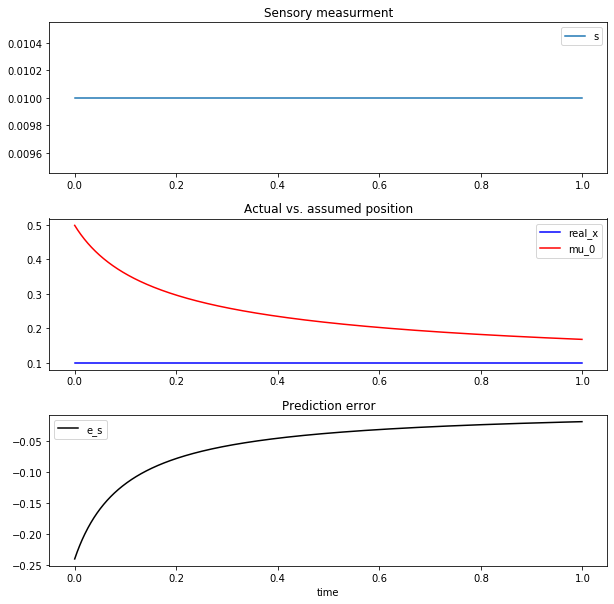

In [61]:
def plot_variables(data):
 
    # Plot variables
 
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(hspace=0.3)

    ax1 = plt.subplot(311)
    ax1.plot( time, data[0, :] )
    ax1.legend(['s'])
    ax1.title.set_text('Sensory measurment')

    ax2 = plt.subplot(312)
    ax2.plot(time, data[1, :], 'b' )  
    ax2.plot(time, data[2, :], 'r' )  
    ax2.legend(['real_x', 'mu_0'])
    ax2.title.set_text('Actual vs. assumed position')

    ax3 = plt.subplot(313)
    ax3.plot(time, data[3, :] , 'k' )  
    ax3.legend(['e_s'])
    ax3.set_xlabel('time')
    ax3.title.set_text('Prediction error')

    plt.show();
    
plot_variables(data)

### Question d.1: Now test the same with the following agent initialization and explain what happened

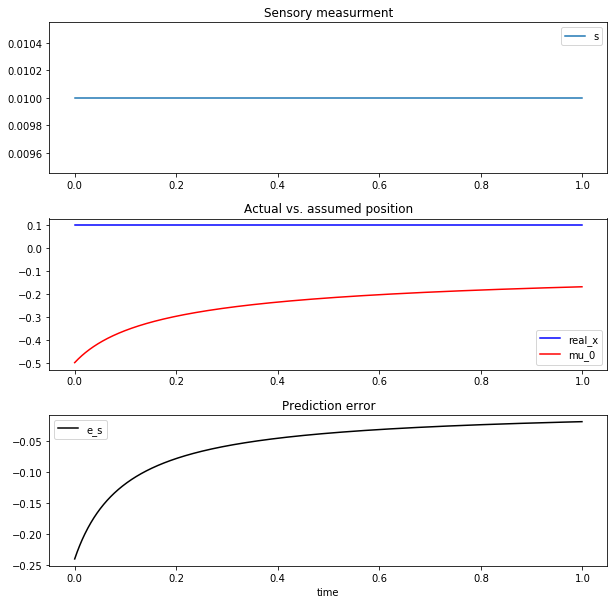

In [62]:
real_x = 0.1    # real position of the ball
mu_0 = -0.5      # internal belief 

data = fep(real_x, mu_0)
plot_variables(data)

$\mu$ now expectedly starts negative and converges to -0.3 instead of 0.1. The important part is that it does approach $real_x$, but it doesn't converge properly (which seems weird)

### Question d.2: Now add different levels of Gaussian noise to the sensor measurements and run the FEP model again

Write a function fep2 with an extra parameter that is the measurement standard deviation $\sigma$, and plot the variables

$s = g(x) + N(0,\sigma^2)$ - Increase $\sigma$ to increase the input noise

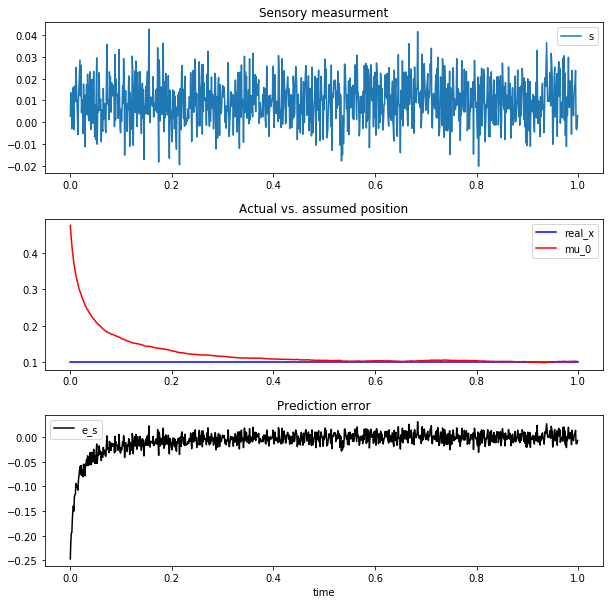

In [58]:
def fep2(real_x, mu_0, measurement_std, sigma_s):
    """
    Takes real position real_x, belief in position mu_0 and standard deviation sigma_s as input and runs FEP for N timesteps

    Returns data which is a 4 x N array that collects s, real_x, mu_0 and e_s for N timesteps

    """

    # Initialize
    N = 1000
    dt = 0.001
    data = np.empty((4, N))
    
    # Run for N timesteps
    for t in range(N):
        # Computations
        s = g(real_x) + np.random.normal(0, measurement_std ** 2)
        mu_dot = dg(mu_0) * sigma_s ** -1 * (s - g(mu_0))
        e_s = (s - g(mu_0))
        
        # Update mu
        mu_0 += mu_dot * dt
        
        # Data
        data[0,t] = s
        data[1,t] = real_x
        data[2,t] = mu_0
        data[3,t] = e_s
    return data


real_x = 0.1    # real position of the ball
mu_0 = 0.5      # internal belief 
measurement_std = 0.1
sigma_s = 0.01    # variance of the sensory process this is for the next exercise

data = fep2(real_x, mu_0, measurement_std, sigma_s)
plot_variables(data)

### Question d.3: Modify the variance parameter $\sigma$ that weights the sensor error accordingly and run it again

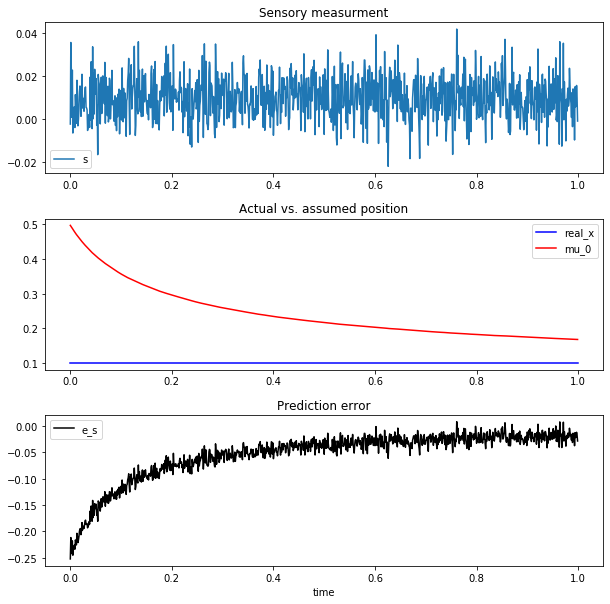

In [59]:
real_x = 0.1    # real position of the ball
mu_0 = 0.5      # internal belief 
measurement_std = 0.1
sigma_s = 0.1    # variance of the sensory process this is for the next exercise

data = fep2(real_x, mu_0, measurement_std, sigma_s)
plot_variables(data)

### Question d.4: How does the system deal with the noise? and what does $\sigma_s$ mean to the agent in normal words?

It still converges somewhat, but it needs more time to reach the actual measurement, so high variance just slows down measurement.


### Question d.5: Now describe how you would implement the action in the FEP mathematical framework

 Actions should give tactile feedback as extra sensory input to get better beliefs